# Cat-Dog predictor using PyTorch
In this project I made use of a convolutional neural network (CNN) to predict if the animal in a photo is a dog or a cat (binary selection). 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image

import os
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [4]:
transform = transforms.Compose([
    transforms.Resize((IMG_WIDTH,IMG_HEIGHT)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=validation_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [5]:
def show_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 4))
    for ax, img in zip(axes, images):
        ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        ax.axis('off')
    plt.show()

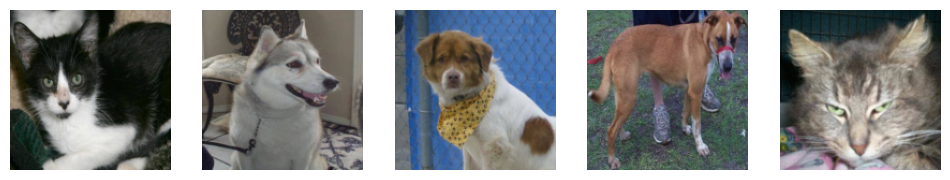

In [6]:
for images, labels in train_loader:
    random_indices = random.sample(range(len(images)), 5)
    random_images = [images[i] for i in random_indices]
    show_images(random_images)
    break 

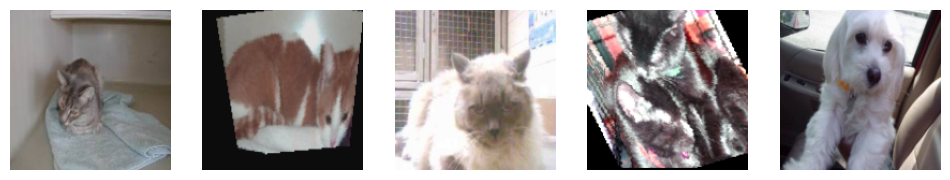

In [7]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomHorizontalFlip(),      
    transforms.RandomRotation(20),           
    transforms.RandomAffine(0, shear=15, scale=(0.85, 1.15)),  
    transforms.RandomPerspective(),          
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.RandomResizedCrop((IMG_HEIGHT, IMG_WIDTH), scale=(0.8, 1.0), ratio=(0.75, 1.333)),  
    transforms.ToTensor(),                 
])

train_dataset_augmented = datasets.ImageFolder(root=train_dir, transform=train_transform)
train_dataset = ConcatDataset([train_dataset,train_dataset_augmented])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for images, labels in train_loader:
    random_indices = random.sample(range(len(images)), 5)
    random_images = [images[i] for i in random_indices]
    show_images(random_images)
    break 

In [8]:
len(train_dataset)

4000

In [43]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.maxPooling = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout2d(p=0.2)  

        self.fc1 = nn.Linear(64 * (IMG_HEIGHT//4) * (IMG_WIDTH//4), 128)  
        self.fc2 = nn.Linear(128, 2)

        
    def forward(self, x):
        x = self.maxPooling(F.relu(self.conv1(x)))
        x = self.maxPooling(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))

        x = self.dropout(x)
        x = x.view(-1,64 * (IMG_HEIGHT//4) * (IMG_WIDTH//4))
        x = torch.flatten(x,1)

        x = F.relu(self.fc1(x))  
        x = self.fc2(x)  
        return x

model = CNN()
model = model.to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxPooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=87616, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

t_acc = []
t_los = []

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for (inputs, labels) in train_loader:
        # Move data to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update running loss
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    t_acc.append((correct/total)*100)
    t_los.append(running_loss/len(train_loader))

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {(correct/total)*100:.2f}%")

Epoch 1/15, Loss: 0.7582, Accuracy: 48.62%
Epoch 2/15, Loss: 0.6929, Accuracy: 51.45%
Epoch 3/15, Loss: 0.6882, Accuracy: 53.57%
Epoch 4/15, Loss: 0.6809, Accuracy: 56.38%
Epoch 5/15, Loss: 0.6750, Accuracy: 58.05%
Epoch 6/15, Loss: 0.6663, Accuracy: 59.50%
Epoch 7/15, Loss: 0.6722, Accuracy: 58.33%
Epoch 8/15, Loss: 0.6481, Accuracy: 61.72%
Epoch 9/15, Loss: 0.6410, Accuracy: 63.00%
Epoch 10/15, Loss: 0.6206, Accuracy: 65.85%
Epoch 11/15, Loss: 0.6069, Accuracy: 66.55%
Epoch 12/15, Loss: 0.5821, Accuracy: 68.95%
Epoch 13/15, Loss: 0.5730, Accuracy: 70.03%
Epoch 14/15, Loss: 0.5765, Accuracy: 69.20%
Epoch 15/15, Loss: 0.5520, Accuracy: 71.70%


In [12]:
# v_acc = []
# v_los = []

# for epoch in range(epochs):
#     running_loss = 0.0
#     correct = 0
#     total = 0
    
#     with torch.no_grad():
#         for (inputs, labels) in val_loader:
#             # Move data to GPU if available
#             inputs, labels = inputs.to(device), labels.to(device)
            
#             # Forward
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
                        
#             # Update running loss
#             running_loss += loss.item()
            
#             # Calculate accuracy
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#             v_acc.append((correct/total)*100)
#             v_los.append(running_loss/len(val_loader))

#         print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(val_loader):.4f}, Accuracy: {(correct/total)*100:.2f}%")

Epoch 1/15, Loss: 0.5877, Accuracy: 68.10%
Epoch 2/15, Loss: 0.5912, Accuracy: 69.50%
Epoch 3/15, Loss: 0.5862, Accuracy: 69.80%
Epoch 4/15, Loss: 0.5834, Accuracy: 69.90%
Epoch 5/15, Loss: 0.5849, Accuracy: 68.40%
Epoch 6/15, Loss: 0.5895, Accuracy: 70.90%
Epoch 7/15, Loss: 0.5770, Accuracy: 70.60%
Epoch 8/15, Loss: 0.6026, Accuracy: 68.20%
Epoch 9/15, Loss: 0.5837, Accuracy: 71.40%
Epoch 10/15, Loss: 0.5946, Accuracy: 70.20%
Epoch 11/15, Loss: 0.5834, Accuracy: 69.60%
Epoch 12/15, Loss: 0.5877, Accuracy: 70.60%
Epoch 13/15, Loss: 0.5897, Accuracy: 69.50%
Epoch 14/15, Loss: 0.5846, Accuracy: 70.80%
Epoch 15/15, Loss: 0.5916, Accuracy: 69.80%


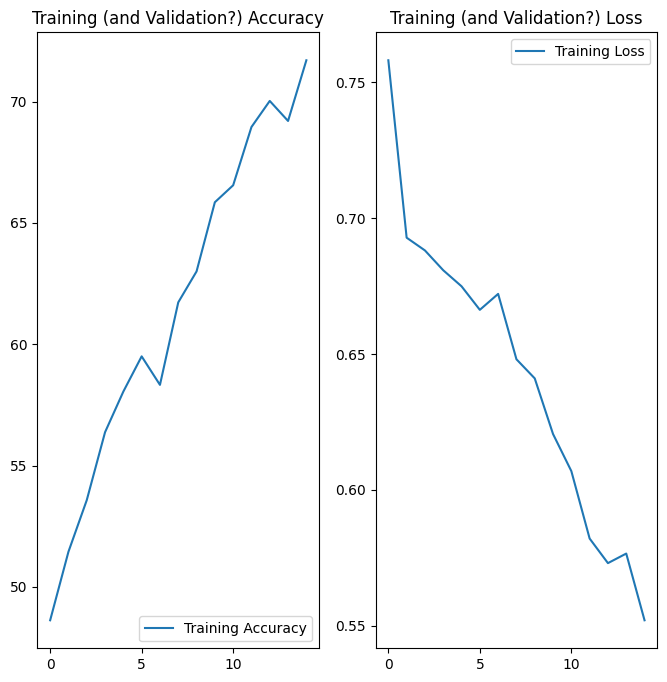

In [45]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, t_acc, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training (and Validation?) Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, t_los, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training (and Validation?) Loss')
plt.show()

In [46]:
for (inputs, labels) in test_loader:
    # Move data to GPU if available
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Forward
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    
print(predicted)

tensor([1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 0], device='cuda:0')


In [47]:
correct = 0

for infer, answer in zip(predicted, labels):
  if infer == answer:
    correct +=1

percentage_identified = (correct / len(predicted)) * 100
print('Final accuracy of: {}%'.format(percentage_identified))

dogs_or_cats_answers = ['Dog' if i==1 else 'Cat' for i in labels]
dogs_or_cats_predict = ['Dog' if i==1 else 'Cat' for i in predicted]

Final accuracy of: 68.0%


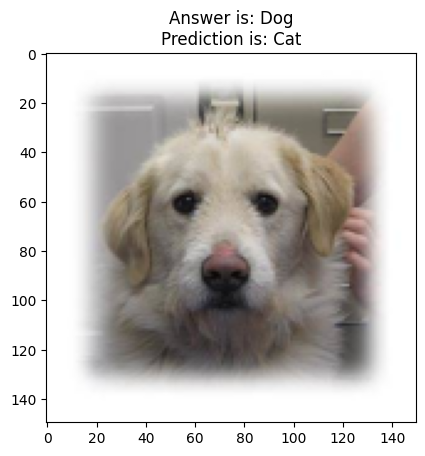

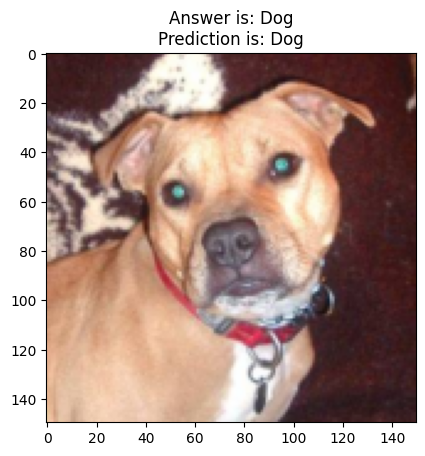

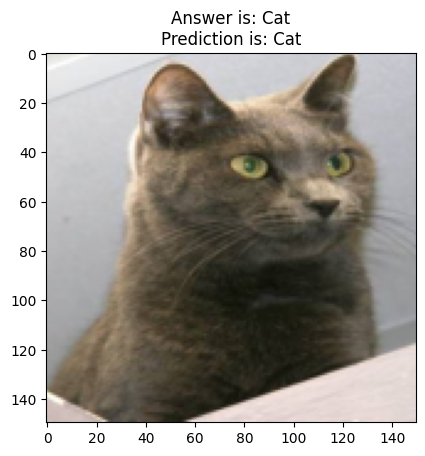

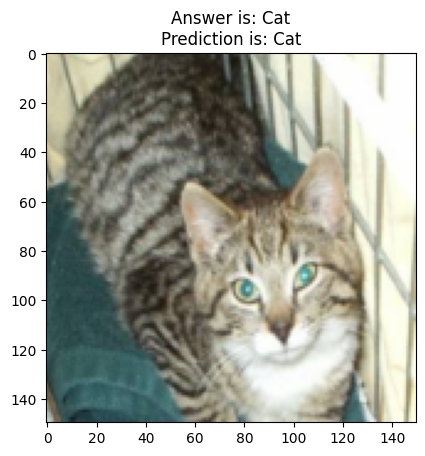

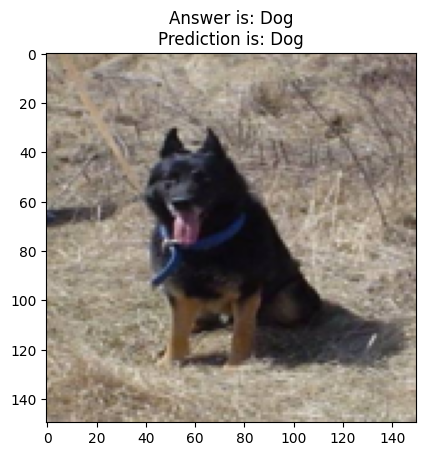

In [49]:
random_indices = random.sample(range(len(images)), 5)

for (images, labels) in test_loader:
    random_images = [images[i] for i in random_indices]

for img, i in zip(random_images,random_indices):
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.title('Answer is: {}\nPrediction is: {}'.format(dogs_or_cats_answers[i], dogs_or_cats_predict[i]))
    plt.show()